In [1]:
#!pip3 install wordcloud
# Installing wordcloud on local machine

# <p style="text-align: center;">Outline</p>
- Importing Necessary Library
- Reading the data
- Splitting the data
- Data cleaning
- EDA (Exploratory Data Analysis)
- Modelling
- Model Evaluation

### <p style="text-align: center;">Importing Necessary Libraries For The Project</p>

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn import model_selection
from wordcloud import STOPWORDS, WordCloud, ImageColorGenerator
import nltk
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer 
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

random_state = 42
np.random.seed(random_state)
#tf.set_random_seed(random_state)

In [3]:
import sys
print(sys.executable)

/opt/anaconda3/bin/python


### <p style="text-align: center;">Reading the Data into Pandas DataFrame</p>

In [4]:
#!/opt/anaconda3/bin/python -m pip install tensorflow
data = pd.read_csv('/Users/user/Downloads/WELFake_Dataset.csv')
data.head()

Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                NaN   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1

In [5]:
data.shape

(72134, 4)

In [6]:
data.isnull().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

### <p style="text-align: center;">Dropping Missing Values</p>

In [7]:
data = data.dropna()
y, X = data.loc[:, 'label'], data.loc[:, data.columns != 'label']
print(f'Total number of observations: {len(X)}\n')
print(f'Percentage of real and fake news:')
y.value_counts(normalize=True).rename({1: 'real', 0: 'fake'})*100

Total number of observations: 71537

Percentage of real and fake news:


real    51.035129
fake    48.964871
Name: label, dtype: float64

The dataset consist of 4 columns and 72,134 rows. The **title**, and **text** columns contain 558, and 39 missing values respectively. I decided to drop the missing data rows since they have no significance on the overall number of rows i.e. 72,134 (a better approach is filling them or doing extensive research on why they are missing). The dataset is almost perfectly balanced since fake news and real news have 49% ~ 50% and 51% proportion in the data. There is no need for balancing.

### <p style="text-align: center;">Data Splitting</p>

In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, 
                                                                    random_state=random_state, stratify=y)

In [9]:
stopwords = set(nltk.corpus.stopwords.words('english'))
porter_stemmer = nltk.stem.PorterStemmer()

### <p style="text-align: center;">Data Cleaning</p>

In [10]:
def remove_urls(text):
    URL_REGEX = r"[(http(s)?):\/\/(www\.)?a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)"
    return re.sub(URL_REGEX, '', text)

def remove_non_alphabetical_characters(text):
    return re.sub('[^a-zA-Z]', ' ', text)
    
def stem_words(text):
    words = text.split()
    return ' '.join(
        [porter_stemmer.stem(word) for word in words if word not in stopwords]
    )

def transform_text(text):
    text = remove_urls(text)
    text = remove_non_alphabetical_characters(text)
    text = text.lower()
    text = stem_words(text)
    
    return text

In [11]:
X_train['title'] = X_train['title'].apply(transform_text)
X_train['text'] = X_train['text'].apply(transform_text)

### <p style="text-align: center;">EDA</p>

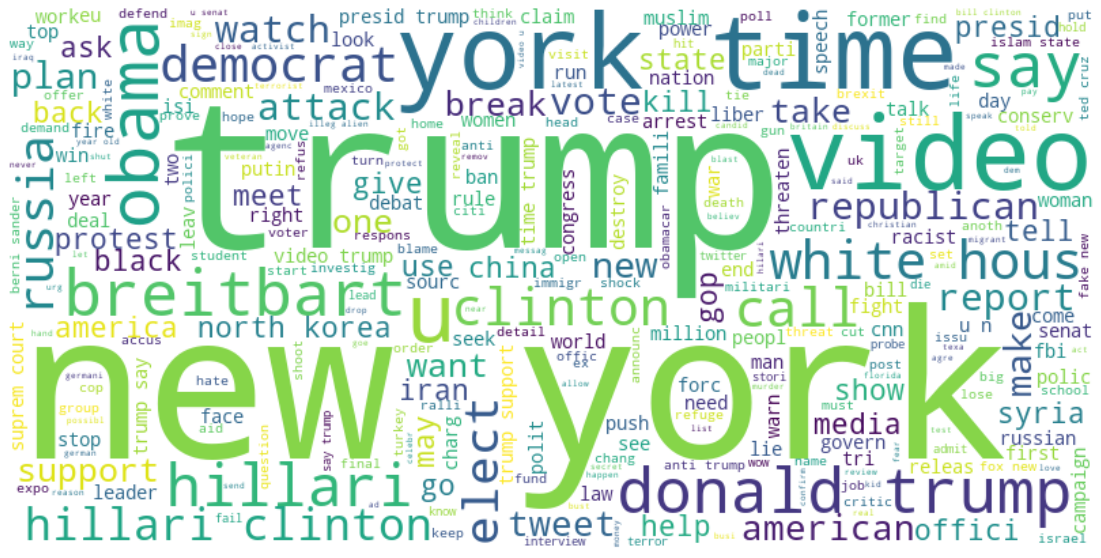

In [12]:
all_titles = ' '.join(title for title in X_train['title'])
wordcloud = WordCloud(
    background_color='white', 
    stopwords=STOPWORDS, 
    max_words=300,
    width=800, 
    height=400,
).generate(all_titles)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

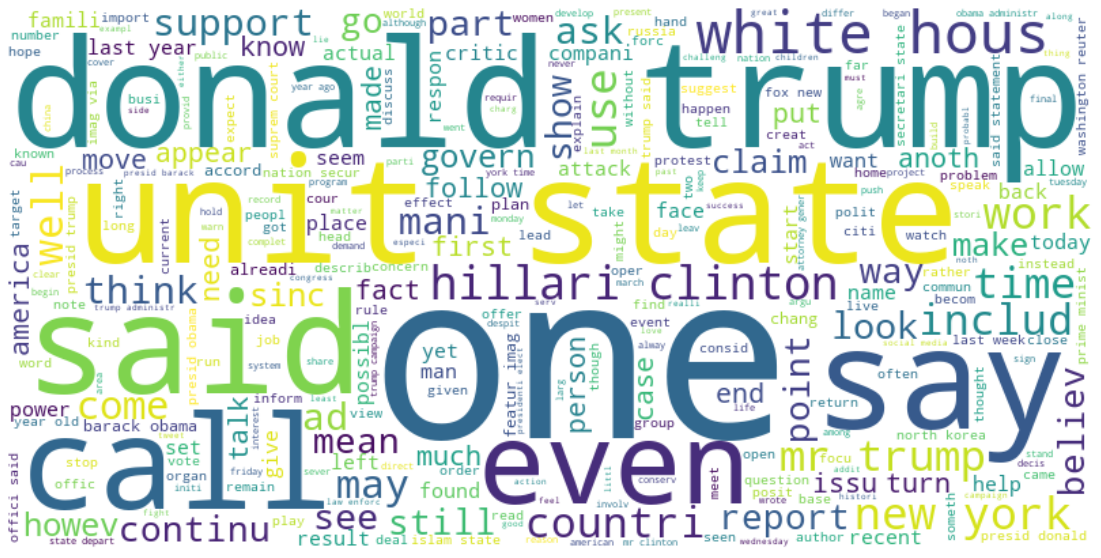

In [13]:
all_news = ' '.join(text for text in X_train['text'])
wordcloud = WordCloud(
    background_color='white',
    stopwords=STOPWORDS,
    max_words=300,
    width=800,
    height=400,
).generate(all_news)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [14]:
fake_news = X_train[y_train == 0]
real_news = X_train[y_train == 1]

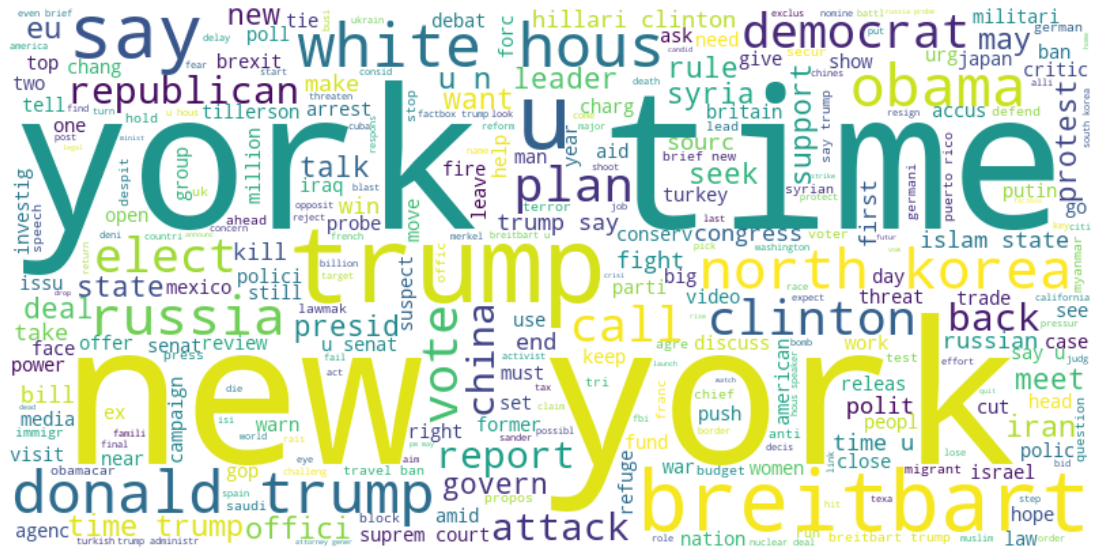

In [15]:
fake_titles = ' '.join(title for title in fake_news['title'])
wordcloud = WordCloud(
    background_color='white', 
    stopwords=STOPWORDS, 
    max_words=300,
    width=800, 
    height=400,
).generate(fake_titles)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

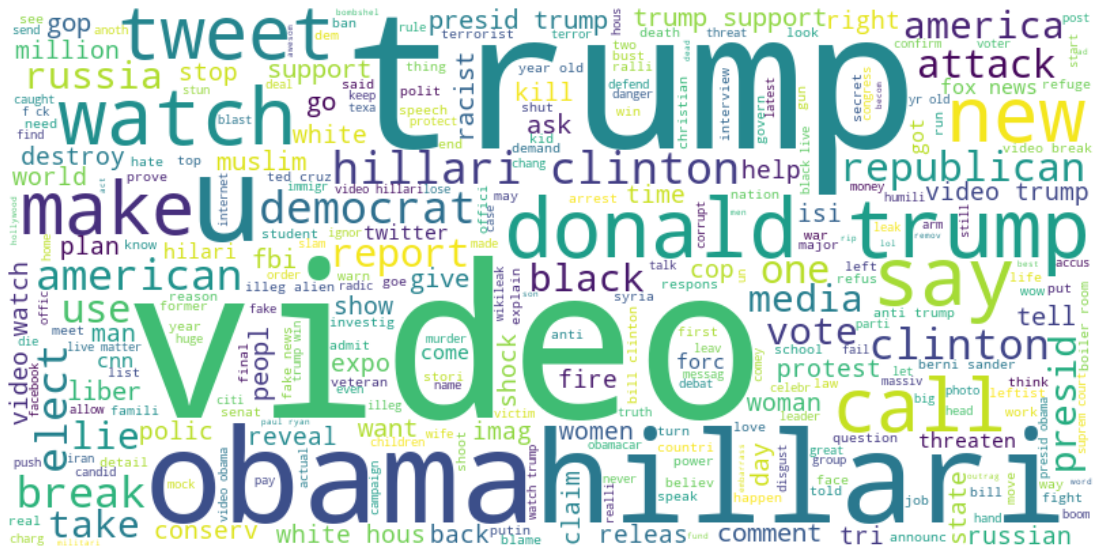

In [16]:
real_titles = ' '.join(title for title in real_news['title'])
wordcloud = WordCloud(
    background_color='white', 
    stopwords=STOPWORDS, 
    max_words=300,
    width=800, 
    height=400,
).generate(real_titles)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [17]:
video_fake, video_real = 0, 0
for title in fake_news['title']:
    if 'video' in title.lower():
        video_fake += 1
for title in real_news['title']:
    if 'video' in title.lower():
        video_real += 1

print(f"Number of times a fake news' title contains word 'video': {video_fake} out of {len(fake_news)}")
print(f"Number of times a real news' title contains word 'video': {video_real} out of {len(real_news)}")

Number of times a fake news' title contains word 'video': 149 out of 24519
Number of times a real news' title contains word 'video': 6239 out of 25556


In [18]:
breitbart_fake, breitbart_real = 0, 0
for title in fake_news['title']:
    if 'breitbart' in title.lower():
        breitbart_fake += 1
for title in real_news['title']:
    if 'breitbart' in title.lower():
        breitbart_real += 1

print(f"Number of times a fake news' title contains word 'Breitbart': {breitbart_fake} out of {len(fake_news)}")
print(f"Number of times a real news' title contains word 'Breitbart': {breitbart_real} out of {len(real_news)}")

Number of times a fake news' title contains word 'Breitbart': 1660 out of 24519
Number of times a real news' title contains word 'Breitbart': 39 out of 25556


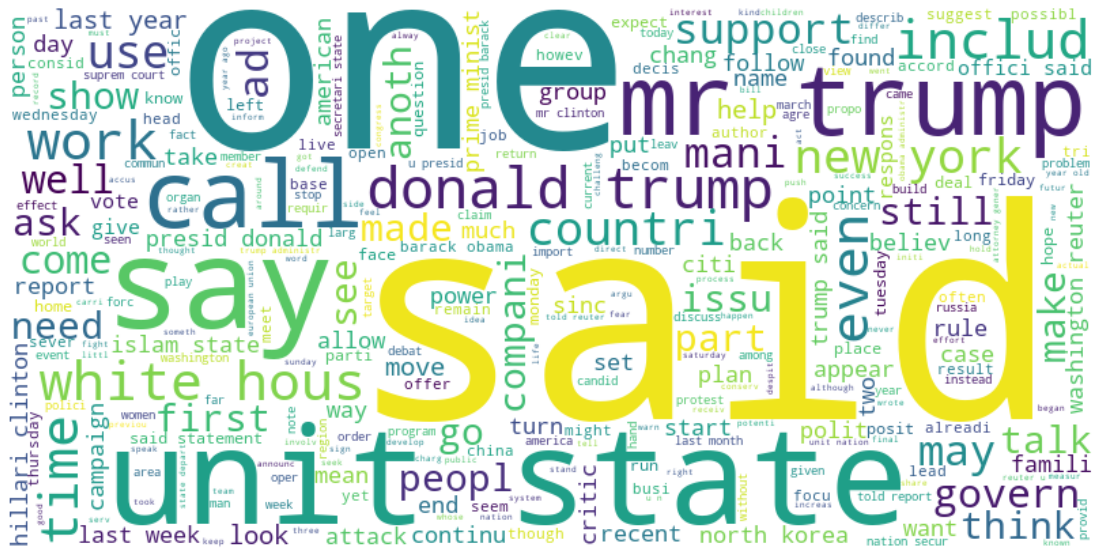

In [19]:
fake_texts = ' '.join(text for text in fake_news['text'])
wordcloud = WordCloud(
    background_color='white', 
    stopwords=STOPWORDS, 
    max_words=300,
    width=800, 
    height=400,
).generate(fake_texts)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

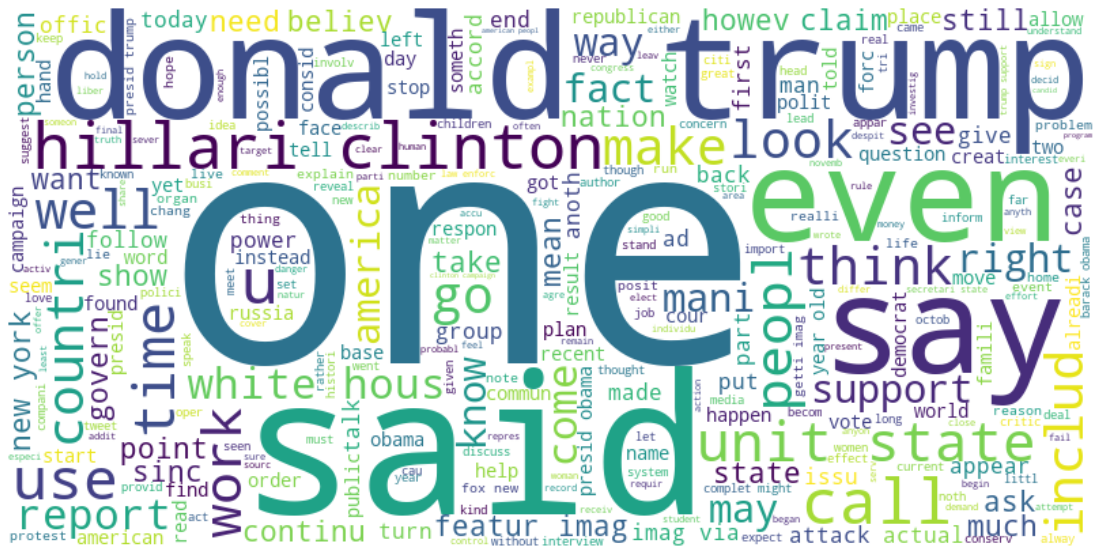

In [20]:
real_texts = ' '.join(text for text in real_news['text'])
wordcloud = WordCloud(
    background_color='white', 
    stopwords=STOPWORDS, 
    max_words=300,
    width=800, 
    height=400,
).generate(real_texts)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [21]:
real_texts = ' '.join(
    ' '.join(set(text.split())) for text in real_news['text']
)
fake_texts = ' '.join(
    ' '.join(set(text.split())) for text in fake_news['text'])

In [22]:
factor = 70

In [23]:
real_texts_list = real_texts.split()
counter_real = Counter(real_texts_list)
counter_real = {k: v / len(real_texts_list) for k, v in counter_real.items()}

fake_texts_list = fake_texts.split()
counter_fake = Counter(fake_texts_list)
counter_fake = {k: v / len(fake_texts_list) for k, v in counter_fake.items()}

In [24]:
for real_word in set(counter_real.keys()).difference(set(counter_fake.keys())):
    freq = counter_real[real_word]
    if freq >= 1 / factor:
        print(real_word, freq)

In [25]:
for fake_word in set(counter_fake.keys()).difference(set(counter_real.keys())):
    freq = counter_fake[fake_word]
    if freq >= 1 / factor:
        print(fake_word, freq)

In [26]:
real_words, fake_words = [], []

for common_word in set(counter_fake.keys()).intersection(set(counter_real.keys())):
    fake_freq, real_freq = counter_fake[common_word], counter_real[common_word]
    
    ratio = real_freq / fake_freq
    if ratio >= factor:
        real_words.append((common_word, ratio))
        
    ratio = fake_freq / real_freq
    if ratio >= factor:
        fake_words.append((common_word, ratio))

In [27]:
print('Words more common in real news:\n')
for real_word, ratio in real_words:
    print(real_word, ratio)
print('\n\n')
print('Words more common in fake news:\n')
for fake_word, ratio in fake_words:
    print(fake_word, ratio)

Words more common in real news:

raedl 153.80772913933544
gmo 89.16390095033938
herein 72.44566952215075
moralist 88.04935218846016
wnd 115.91307123544121
screengrab 116.47034561638084
utc 89.16390095033938
como 84.70570590282243
getti 233.5775762395498
cdata 111.45487618792424
fj 124.82946133047514
flickr 286.9963061839049
gage 72.44566952215075
spore 82.47660837906395



Words more common in fake news:

yangon 79.85294411878128
suu 128.30304504478337
kyi 128.30304504478337
rohingya 78.65664533048492


In [28]:
df = data.dropna()

In [29]:
title = df['title'].tolist()
text = df["text"].tolist()
labels = df['label'].tolist()
title[:5]

['LAW ENFORCEMENT ON HIGH ALERT Following Threats Against Cops And Whites On 9-11By #BlackLivesMatter And #FYF911 Terrorists [VIDEO]',
 'UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MOST CHARLOTTE RIOTERS WERE “PEACEFUL” PROTESTERS…In Her Home State Of North Carolina [VIDEO]',
 'Bobby Jindal, raised Hindu, uses story of Christian conversion to woo evangelicals for potential 2016 bid',
 'SATAN 2: Russia unvelis an image of its terrifying new ‘SUPERNUKE’ – Western world takes notice',
 'About Time! Christian Group Sues Amazon and SPLC for Designation as Hate Group']

In [30]:
training_size = int(len(title) * 0.7)

training_sentences = title[0:training_size]
testing_sentences = title[training_size:]

training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

len(training_sentences),len(testing_sentences)

(50075, 21462)

In [31]:
vocab_size = 500
embedding_dim = 16
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [32]:
reversed_index = [ (value,key) for (key,value) in word_index.items()] 

In [33]:
training_sequences[:5]

[[129, 1, 8, 374, 1, 1, 1, 60, 425, 12, 1, 8, 338, 1, 1, 12, 1, 1, 10],
 [1, 107, 408, 298, 19, 189, 1, 1, 435, 1, 1, 64, 359, 54, 6, 66, 1, 10],
 [1, 1, 1, 1, 1, 439, 6, 1, 1, 2, 1, 1, 7, 1, 154, 1],
 [1, 221, 46, 1, 88, 466, 6, 281, 1, 9, 1, 56, 1, 121, 282, 1],
 [29, 147, 1, 283, 1, 1, 12, 1, 7, 1, 25, 479, 283]]

In [34]:
text = ""
for i in range(len(training_sequences[0])):
    text += reversed_index[training_sequences[0][i]][1]
    text += " "
text

'man to new work to to to was 6 york to new order to to york to to a '

### <p style="text-align: center;">Modelling</p>

In [35]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 8,109
Trainable params: 8,109
Non-trainable params: 0
_________________________________________________________________


2022-07-30 23:49:22.197566: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [36]:
num_epochs = 30
history = model.fit(training_padded, training_labels_final, 
                    epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/30
1565/1565 [==============================] - 4s 2ms/step - loss: 0.4455 - accuracy: 0.8099 - val_loss: 0.3205 - val_accuracy: 0.8595
Epoch 2/30
1565/1565 [==============================] - 3s 2ms/step - loss: 0.2982 - accuracy: 0.8688 - val_loss: 0.3054 - val_accuracy: 0.8638
Epoch 3/30
1565/1565 [==============================] - 3s 2ms/step - loss: 0.2895 - accuracy: 0.8723 - val_loss: 0.3017 - val_accuracy: 0.8676
Epoch 4/30
1565/1565 [==============================] - 3s 2ms/step - loss: 0.2882 - accuracy: 0.8734 - val_loss: 0.3040 - val_accuracy: 0.8647
Epoch 5/30
1565/1565 [==============================] - 3s 2ms/step - loss: 0.2869 - accuracy: 0.8742 - val_loss: 0.3054 - val_accuracy: 0.8637
Epoch 6/30
1565/1565 [==============================] - 3s 2ms/step - loss: 0.2863 - accuracy: 0.8742 - val_loss: 0.3023 - val_accuracy: 0.8669
Epoch 7/30
1565/1565 [==============================] - 3s 2ms/step - loss: 0.2856 - accuracy: 0.8746 - val_loss: 0.3037 - val_accuracy:

### <p style="text-align: center;">Model Evaluation</p>

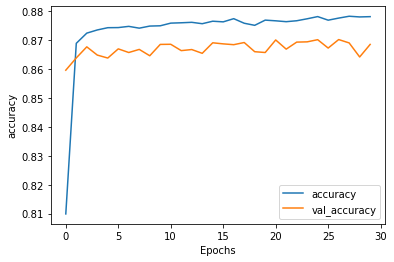

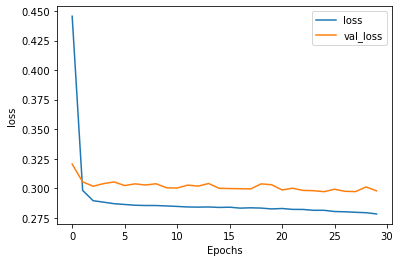

In [37]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [38]:
preds = model.predict(testing_padded)

671/671 [==============================] - 2s 2ms/step


In [39]:
def roundArray(number):
    ret = 0
    if number > 0.5:
        ret = 1
    return ret 

preds = preds.flatten()
result = list(map(roundArray, preds))
result[:10]

[0, 1, 1, 1, 1, 0, 0, 1, 0, 1]

In [40]:
title = df['title'].tolist()
labels = df['label'].tolist()

training_size = int(len(title) * 0.7)

testing_sentences = title[training_size:]
testing_labels = labels[training_size:]

In [41]:
testing_labels[:10]

[0, 1, 1, 1, 1, 0, 1, 1, 0, 1]

In [42]:
error = 0

for i in range(len(result)):
    res = result[i]
    true = testing_labels[i]
    if res != true:
        error += 1
        
error,len(result),(len(result)-error)/len(result)*100

(2824, 21462, 86.84186003168391)

In [43]:
model.history

### <p style="text-align: center;">The End</p>